In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time

In [2]:
class AP_NN(nn.Module):
    def __init__(self, K_no, L_no, H_no, T_no, device):
        super().__init__()
        
        self.K_no = K_no
        self.L_no = L_no
        self.H_no = H_no
        self.T_no = T_no
        self.device = device
        
        nn_list = []
        for l in range(self.L_no):
            if l == 0:
                nn_list.append(nn.Conv1d(in_channels=2, out_channels=H_no, kernel_size=K_no, padding=0))
                #nn_list.append(nn.Tanh())
                nn_list.append(nn.LeakyReLU())
            elif l == self.L_no - 1:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=1, kernel_size=1, padding=0))
            else:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=H_no, kernel_size=1, padding=0))
                #nn_list.append(nn.Tanh())
                nn_list.append(nn.LeakyReLU())
        
        self.nn = nn.Sequential(*nn_list)
        
    def forward(self, V, D):
        #V, D, S is shape (batch, 50000)
        
        input_pad = torch.zeros(V.shape[0], 2, V.shape[1] + self.K_no-1).to(self.device)
        input_pad[:,0,-V.shape[1]:] = input_pad[:,0,-V.shape[1]:] + V
        input_pad[:,1,-D.shape[1]:] = input_pad[:,1,-D.shape[1]:] + D
        
        nn_out = self.nn(input_pad).squeeze(1) # (batch, 50000)
        P = torch.sigmoid(nn_out)
        S = torch.bernoulli(P)
        return S, P



In [3]:
batch_size = 5
batch_length = 50000
K_no = 1
L_no = 2
H_no = 20
T_no = 501
device = torch.device("cuda")

epoch_no = 200
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy").flatten()

#D = np.zeros((V.shape[0]))
#D[:-1] = np.diff(V)
#D = V.copy()
D_train = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_extra_output.npz")["test"]
D_test = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_output.npz")["test"]
D_train = torch.from_numpy(D_train).float()
D_test = torch.from_numpy(D_test).float().to(device)

#D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spk.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
#D = torch.from_numpy(D)
S = torch.from_numpy(S)



In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
#D_train = D[:980].float()
#D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_NN(K_no, L_no, H_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

81


In [6]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out, batch_P = model(batch_V, batch_D)
    loss = bce_criterion(batch_P, batch_S)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%250 == 249) or (i == 0):
        model.eval()
        test_S_out, P_test = model(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = bce_criterion(P_test, S_test[:,part_time_idx]).item()
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-a095aa4c932e>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/39200 [00:00<?, ?it/s]

0 0.5619990229606628 0.2415297031402588
249 0.22205206751823425 0.0027344226837158203
499 0.09452523291110992 0.0030183792114257812
749 0.04747508093714714 0.0027866363525390625
999 0.02822178229689598 0.003253936767578125
1249 0.019199863076210022 0.0028166770935058594
1499 0.014416379854083061 0.0033180713653564453
1749 0.011643127538263798 0.0027511119842529297
1999 0.009904954582452774 0.003522157669067383
2249 0.00873741414397955 0.007536888122558594
2499 0.007895885035395622 0.003466367721557617
2749 0.007247979752719402 0.0023202896118164062
2999 0.006719075608998537 0.0033659934997558594
3249 0.006270972546190023 0.0027124881744384766
3499 0.005873414687812328 0.0023679733276367188
3749 0.005504750180989504 0.003260374069213867
3999 0.005165820010006428 0.0027871131896972656
4249 0.004878559615463018 0.0033597946166992188
4499 0.00462962593883276 0.0027713775634765625
4749 0.004401098471134901 0.002542734146118164
4999 0.00419588852673769 0.002163410186767578
5249 0.00401347549

KeyboardInterrupt: 

In [7]:
# 2649 0.004261615686118603 (true_na with refractory)
# 31249 0.0029351413249969482  (true_na without refractory)
# 35499 0.0030055860988795757  (comb_pred without refractory)
# 29749 0.003061493393033743  (whole_pred without refractory)


# AP True
# 0.00019483866344671696 (V, D)
# 0.0006420775316655636 (V only)

# Na True
# 0.0012602820061147213 (V, D)
# 0.0018874892266467214 (V only)

# No Na True
# 0.0013189633609727025 (V, D)
# 0.0018882722361013293 (V only)

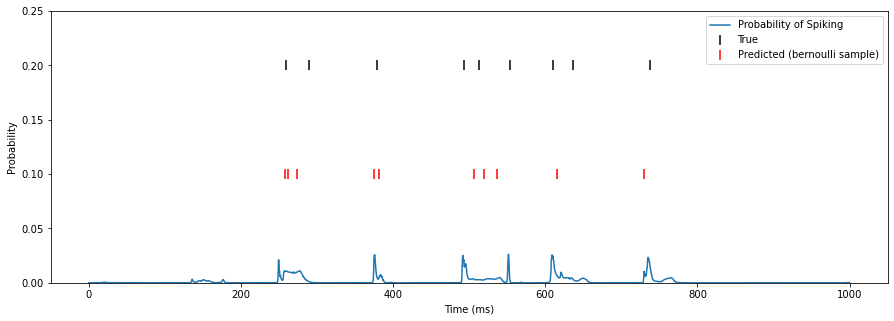

In [7]:
plt.figure(figsize = (15,5))
plt.plot(np.arange(0,1000,0.2), P_test[0][10000:15000].cpu().detach().numpy()[:], label="Probability of Spiking")
plt.scatter(np.arange(0,1000,0.2), S_test[0][12000:32000][10000:15000].cpu().detach().numpy()-0.8, s=100, color="black", marker="|", label="True")
plt.scatter(np.arange(0,1000,0.2), test_S_out[0][10000:15000].cpu().detach().numpy()*0.9-0.8, s=100, color="red", marker="|", label="Predicted (bernoulli sample)")
plt.ylim(0,0.25)
plt.xlabel("Time (ms)")
plt.ylabel("Probability")
plt.legend()